In [1]:
import warnings
warnings.filterwarnings('ignore')
import re
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import gzip
import shutil
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fbprophet import Prophet
from collections import defaultdict

In [2]:
# original data input
dfp = pd.read_csv('USDC Price.csv')


In [3]:
print(dfp)


           Date  USDC Price
0    2018-10-08    1.002210
1    2018-10-09    1.006860
2    2018-10-10    1.009620
3    2018-10-11    1.009780
4    2018-10-12    1.012720
..          ...         ...
919  2021-04-14    0.999534
920  2021-04-15    0.999178
921  2021-04-16    0.999518
922  2021-04-17    0.999383
923  2021-04-18    0.998674

[924 rows x 2 columns]


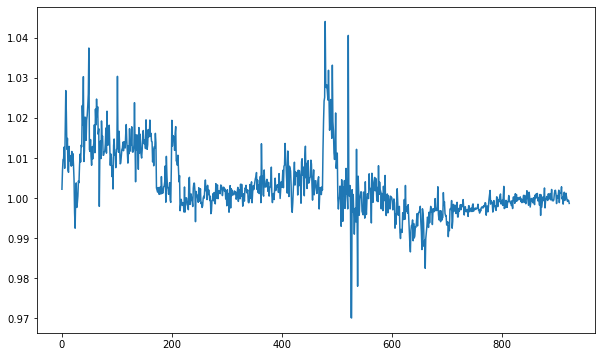

In [4]:
# Time Series Plot
plt.rcParams['figure.figsize'] = (10,6)
dfp['USDC Price'] = dfp['USDC Price'].astype('float64')
plt.plot(dfp['USDC Price'])
plt.show()


In [5]:
#split train and test
from sklearn.model_selection import train_test_split

usdc_train=dfp[dfp['Date']<='2021-01-07']
usdc_test =dfp[dfp['Date']>'2021-01-07']

print(usdc_train)
print(usdc_test)


           Date  USDC Price
0    2018-10-08    1.002210
1    2018-10-09    1.006860
2    2018-10-10    1.009620
3    2018-10-11    1.009780
4    2018-10-12    1.012720
..          ...         ...
818  2021-01-03    0.998120
819  2021-01-04    0.999354
820  2021-01-05    0.997401
821  2021-01-06    1.000171
822  2021-01-07    1.000320

[823 rows x 2 columns]
           Date  USDC Price
823  2021-01-08    0.999768
824  2021-01-09    0.998707
825  2021-01-10    1.001093
826  2021-01-11    0.999213
827  2021-01-12    1.000892
..          ...         ...
919  2021-04-14    0.999534
920  2021-04-15    0.999178
921  2021-04-16    0.999518
922  2021-04-17    0.999383
923  2021-04-18    0.998674

[101 rows x 2 columns]


In [6]:
usdc_train['Date'] = pd.to_datetime(usdc_train['Date'])
usdc_train = usdc_train[['Date','USDC Price']].set_index('Date')

usdc_test['Date'] = pd.to_datetime(usdc_test['Date'])
usdc_test = usdc_test[['Date','USDC Price']].set_index('Date')


print(usdc_train)
print(usdc_test)


            USDC Price
Date                  
2018-10-08    1.002210
2018-10-09    1.006860
2018-10-10    1.009620
2018-10-11    1.009780
2018-10-12    1.012720
...                ...
2021-01-03    0.998120
2021-01-04    0.999354
2021-01-05    0.997401
2021-01-06    1.000171
2021-01-07    1.000320

[823 rows x 1 columns]
            USDC Price
Date                  
2021-01-08    0.999768
2021-01-09    0.998707
2021-01-10    1.001093
2021-01-11    0.999213
2021-01-12    1.000892
...                ...
2021-04-14    0.999534
2021-04-15    0.999178
2021-04-16    0.999518
2021-04-17    0.999383
2021-04-18    0.998674

[101 rows x 1 columns]


In [7]:
print(usdc_train.shape, usdc_test.shape)

(823, 1) (101, 1)


In [8]:
dfp['Date'] = pd.to_datetime(dfp['Date'])
dfp = dfp[['Date','USDC Price']].set_index('Date')



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


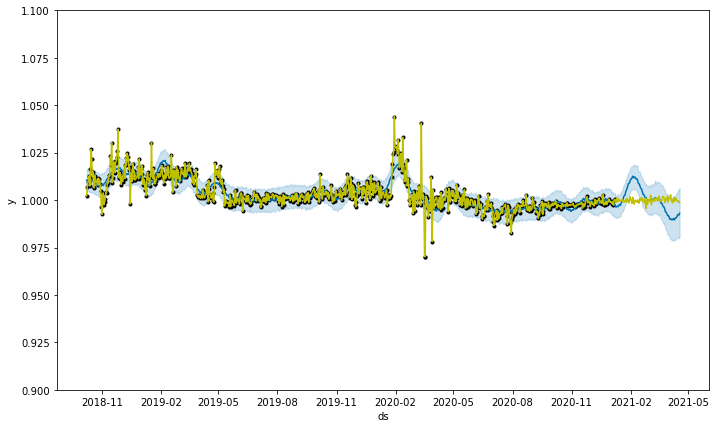

In [9]:
from fbprophet import Prophet

# Prophet requires the time series to be a 2 column data series with the Date as 'ds' and the values as 'y'.

usdc_train_pro = usdc_train.reset_index()
usdc_test_pro = usdc_test.reset_index()
usdc_train_pro = usdc_train_pro.rename({'Date':'ds', 'USDC Price':'y'}, axis='columns')
usdc_test_pro = usdc_test_pro.rename({'Date':'ds', 'USDC Price':'y'}, axis='columns')
dfp_pro = dfp.reset_index()
dfp_pro=dfp_pro.rename({'Date':'ds', 'USDC Price':'y'}, axis='columns')
usdc_prophet = Prophet()


# Fit the model on the time series.
m_prophet = usdc_prophet.fit(usdc_train_pro)


# Create a DataFrame of future dates to create forecasts for. 
future_prophet = m_prophet.make_future_dataframe(periods=101)

# Create forecast
prophet_forecast = m_prophet.predict(future_prophet)

fig1 = m_prophet.plot(prophet_forecast)

plt.plot(dfp['USDC Price'], c = 'y')
plt.ylim([0.9, 1.1])
plt.grid()
plt.show()

In [10]:
def get_mape(actuals, forecasts):
    #np.set_printoptions(precision=5)
    MAPE = np.mean(np.abs(actuals - forecasts)/actuals)
    return MAPE
prophet_forecast = prophet_forecast.reset_index().rename(columns = {'ds':'Date', 'yhat':'USDC Price'})
prophet_forecast = prophet_forecast.set_index('Date')

prophet_mape = get_mape(usdc_test['USDC Price'], prophet_forecast['USDC Price'])


print('Original Prophet MAPE: ', prophet_mape)

Original Prophet MAPE:  0.00552052465414483
